In [3]:
from os.path import basename, exists
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import json
from matplotlib.colors import ListedColormap

In [4]:
# Load the data from MITRE ATT&CK softwares (https://attack.mitre.org/software/)
with open('software_techniques.json') as f:
    software_techniques = json.load(f)

In [5]:

# Load the data from the tactics json file
with open('tactics_techniques.json') as f:
    tactics_data = json.load(f)

# TODO: fix one to many mapping
# Convert tactics data to a dictionary
tactics_dict = {}
step = 0 # The step of the tactic. Used to sort techniques later.
for item in tactics_data:
    for technique in item["techniques"]:
        tactics_dict[technique["id"]] = (step, item["tactic"])
    step += 1

In [7]:
# Maps to store nodes of each tactic
tactics = {
    'Initial Access': set(),
    'Execution': set(),
    'Persistence': set(),
    'Privilege Escalation': set(),
    'Defense Evasion': set(),
    'Credential Access': set(),
    'Discovery': set(),
    'Lateral Movement': set(),
    'Collection': set(),
    'Command and Control': set(),
    'Exfiltration': set(),
    'Impact': set(),
}

colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue', 'purple', 'violet', 'brown', 'pink', 'grey']

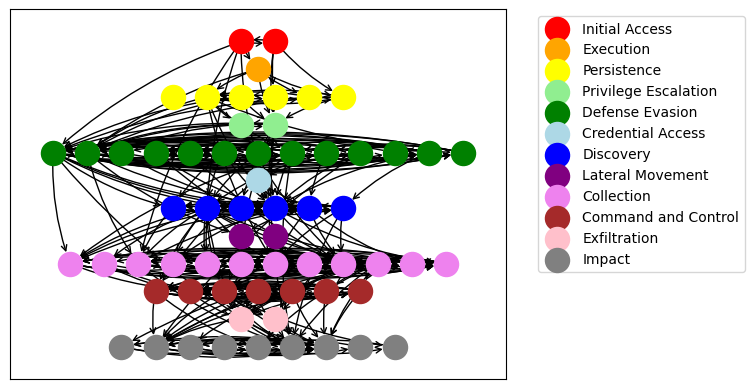

In [24]:
from queue import PriorityQueue


G = nx.DiGraph()

pos = {}

for software in software_techniques:
    software_techniques_pq = PriorityQueue()
    for technique in software["techniques"]:
        technique_id = technique["technique_id"]
        step = tactics_dict.get(technique_id)[0]
        software_techniques_pq.put((step, technique_id))

    prev_technique_id = None
    prev_step = None
    
    while not software_techniques_pq.empty():
        technique = software_techniques_pq.get()
        step = technique[0]
        technique_id = technique[1]
        tactic = tactics_dict.get(technique_id)[1]
        if tactic:
            G.add_node(technique_id, tactic=tactic)
            tactics[tactic].add(technique_id)
        if prev_technique_id is not None and technique_id != prev_technique_id:
            G.add_edge(prev_technique_id, technique_id)
            if prev_step is not None and prev_step == step:
                G.add_edge(technique_id, prev_technique_id)
        prev_step = step
        prev_technique_id = technique_id

# Calculate the number of techniques in each tactic
tactic_counts = {tactic: len(nodes) for tactic, nodes in tactics.items()}

# Calculate the spacing between nodes within each tactic
spacing = 1 / max(tactic_counts.values())

# Set the initial y-position for each tactic
y_positions = {tactic: -i for i, tactic in enumerate(tactics.keys())}

# used for centering
max_count = max(tactic_counts.values())

# Set the positions for the nodes within each tactic
for tactic, nodes in tactics.items():
    y = y_positions[tactic]
    for i, node in enumerate(nodes):
        # center graph
        x = i * spacing + max_count - tactic_counts[tactic] * spacing / 2
        pos[node] = (x, y)

# Draw the nodes and edges
for tactic, color in zip(tactics.keys(), colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=tactics[tactic], node_color=color, label=tactic)
nx.draw_networkx_edges(G, pos=pos, arrows=True, arrowstyle='->', connectionstyle='arc3,rad=0.1')  # Set arrows=True, arrowstyle='->', and connectionstyle='arc3,rad=0.1'

# Add labels for the nodes
# labels = {node: node for node in G.nodes()}
# nx.draw_networkx_labels(G, pos=pos, labels=labels)

# Adjust the position of the legend
plt.legend(scatterpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('figs/degree_centrality/attack_paths_network_graph.png', dpi=300, bbox_inches='tight')

plt.show()

In [32]:
degree_centrality = nx.degree_centrality(G)
degree_centrality

{'T1626': 0.06451612903225806,
 'T1517': 0.08064516129032258,
 'T1437': 0.29032258064516125,
 'T1429': 0.25806451612903225,
 'T1623': 0.0967741935483871,
 'T1533': 0.3064516129032258,
 'T1407': 0.3709677419354839,
 'T1646': 0.22580645161290322,
 'T1404': 0.22580645161290322,
 'T1629': 0.16129032258064516,
 'T1544': 0.0967741935483871,
 'T1430': 0.3870967741935484,
 'T1406': 0.3225806451612903,
 'T1636': 0.3387096774193548,
 'T1418': 0.1935483870967742,
 'T1426': 0.1935483870967742,
 'T1422': 0.1774193548387097,
 'T1512': 0.1774193548387097,
 'T1633': 0.0967741935483871,
 'T1474': 0.0967741935483871,
 'T1577': 0.04838709677419355,
 'T1643': 0.22580645161290322,
 'T1628': 0.27419354838709675,
 'T1630': 0.2096774193548387,
 'T1424': 0.0967741935483871,
 'T1624': 0.27419354838709675,
 'T1644': 0.0967741935483871,
 'T1481': 0.08064516129032258,
 'T1532': 0.06451612903225806,
 'T1616': 0.11290322580645161,
 'T1471': 0.08064516129032258,
 'T1417': 0.3064516129032258,
 'T1513': 0.0967741935483

In [33]:
# Create a dictionary to map IDs to names
id_to_name = {}
for tactic in tactics_data:
    for technique in tactic['techniques']:
        id_to_name[technique['id']] = technique['name']

# Create a new dictionary with names as keys
degree_centrality_names = {}
for id, centrality in degree_centrality.items():
    name = id_to_name.get(id, id)  # If the ID is not found in the mapping, use the ID itself
    degree_centrality_names[name] = centrality

In [34]:
for name, centrality in degree_centrality_names.items():
    print(f"{name}: {centrality}")

Abuse Elevation Control Mechanism: 0.06451612903225806
Access Notifications: 0.08064516129032258
Application Layer Protocol: 0.29032258064516125
Audio Capture: 0.25806451612903225
Command and Scripting Interpreter: 0.0967741935483871
Data from Local System: 0.3064516129032258
Download New Code at Runtime: 0.3709677419354839
Exfiltration Over C2 Channel: 0.22580645161290322
Exploitation for Privilege Escalation: 0.22580645161290322
Impair Defenses: 0.16129032258064516
Ingress Tool Transfer: 0.0967741935483871
Location Tracking: 0.3870967741935484
Obfuscated Files or Information: 0.3225806451612903
Protected User Data: 0.3387096774193548
Software Discovery: 0.1935483870967742
System Information Discovery: 0.1935483870967742
System Network Configuration Discovery: 0.1774193548387097
Video Capture: 0.1774193548387097
Virtualization/Sandbox Evasion: 0.0967741935483871
Supply Chain Compromise: 0.0967741935483871
Compromise Application Executable: 0.04838709677419355
Generate Traffic from Vic

In [35]:
# Find the minimum and maximum centrality scores
min_score = min(degree_centrality_names.values())
max_score = max(degree_centrality_names.values())

# Perform min-max normalization on the centrality scores
normalized_scores = {}
for name, centrality in degree_centrality_names.items():
    normalized_score = (centrality - min_score) / (max_score - min_score)
    normalized_scores[name] = normalized_score

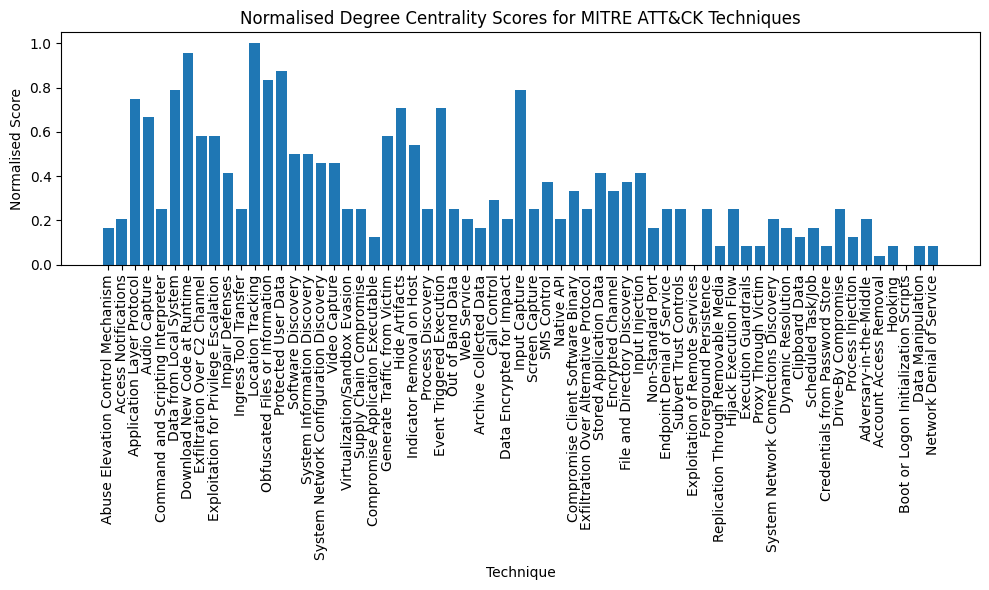

In [36]:
# Prepare the data for plotting
names = list(normalized_scores.keys())
scores = list(normalized_scores.values())

# Plot the normalized scores
plt.figure(figsize=(10, 6))
plt.bar(names, scores)
plt.xlabel('Technique')
plt.ylabel('Normalised Score')
plt.title('Normalised Degree Centrality Scores for MITRE ATT&CK Techniques')
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig('figs/degree_centrality/techniques_degree_centrality_normalised.png', dpi=300, bbox_inches='tight')

plt.show()

In [37]:
import requests
from bs4 import BeautifulSoup
import time

base_url = "https://attack.mitre.org"

def get_mitigations(url):
    mitigations = {}

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # find and loop through each row in the table
    for row in soup.find_all('tr'):
        cells = row.find_all('td')
        if len(cells) > 1:
            mitigation_name = cells[1].text.strip()
            mitigation_link = cells[0].find('a')['href']

            techniques = get_techniques(base_url + mitigation_link)

            # Add the set of techniques to the dictionary
            mitigations[mitigation_name] = techniques

            # Avoid making requests too quickly
            time.sleep(1)

    return mitigations

def get_techniques(url):
    techniques = set()

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # find and loop through each row in the techniques addressed table
    techniques_table = soup.find("table", class_="table techniques-used background table-bordered")
    if techniques_table:
        for row in techniques_table.find_all('tr', class_='technique mobile'):
            cells = row.find_all('td')
            if len(cells) > 1:
                technique_name = cells[-2].text.strip() 
                techniques.add(technique_name)

    return techniques

# Scrape the data
mitigations = get_mitigations("https://attack.mitre.org/mitigations/mobile/")

# Print the data
print(mitigations)


{'Application Developer Guidance': {'Screen Capture', 'Steal Application Access Token', 'Supply Chain Compromise', 'Access Notifications', 'Abuse Elevation Control Mechanism'}, 'Attestation': {'Process Discovery', 'Compromise Client Software Binary', 'Credentials from Password Store', 'Indicator Removal on Host', 'Boot or Logon Initialization Scripts', 'Hijack Execution Flow', 'Command and Scripting Interpreter', 'Hooking', 'Exploitation for Privilege Escalation'}, 'Deploy Compromised Device Detection Method': {'Exploitation for Privilege Escalation', 'Credentials from Password Store', 'Hooking', 'Command and Scripting Interpreter', 'Impair Defenses'}, 'Encrypt Network Traffic': {'Adversary-in-the-Middle'}, 'Enterprise Policy': {'Replication Through Removable Media', 'Location Tracking', 'Screen Capture', 'Input Capture', 'Exploitation of Remote Services', 'Subvert Trust Controls', 'Access Notifications', 'Input Injection', 'Impair Defenses', 'Lockscreen Bypass'}, 'Interconnection Filt

In [38]:
mitigation_degree_centrality = {}
for mitigation, techniques in mitigations.items():
    degree_centrality_sum = 0
    for technique in techniques:
        degree_centrality = degree_centrality_names.get(technique, 0)
        degree_centrality_sum += degree_centrality
    mitigation_degree_centrality[mitigation] = degree_centrality_sum
    
for mitigation, centrality in mitigation_degree_centrality.items():
    print(f"{mitigation}: {centrality}")

Application Developer Guidance: 0.3387096774193548
Attestation: 0.9193548387096774
Deploy Compromised Device Detection Method: 0.5483870967741935
Encrypt Network Traffic: 0.08064516129032258
Enterprise Policy: 1.3225806451612905
Interconnection Filtering: 0.3870967741935484
Lock Bootloader: 0.16129032258064516
Security Updates: 1.0322580645161288
System Partition Integrity: 0.3870967741935484
Use Recent OS Version: 3.354838709677418
User Guidance: 3.14516129032258


In [39]:
# Normalise the data 
min_value = min(mitigation_degree_centrality.values())
max_value = max(mitigation_degree_centrality.values())

normalised_mit_degree = {key: (value - min_value) / (max_value - min_value) for key, value in mitigation_degree_centrality.items()}

print("--Normalised mitigation degree centrality--")
for key, value in normalised_mit_degree.items():
    print(f"{key}: {value}")

--Normalised mitigation degree centrality--
Application Developer Guidance: 0.07881773399014781
Attestation: 0.25615763546798037
Deploy Compromised Device Detection Method: 0.1428571428571429
Encrypt Network Traffic: 0.0
Enterprise Policy: 0.3793103448275864
Interconnection Filtering: 0.09359605911330053
Lock Bootloader: 0.02463054187192119
Security Updates: 0.29064039408867
System Partition Integrity: 0.09359605911330053
Use Recent OS Version: 1.0
User Guidance: 0.9359605911330051


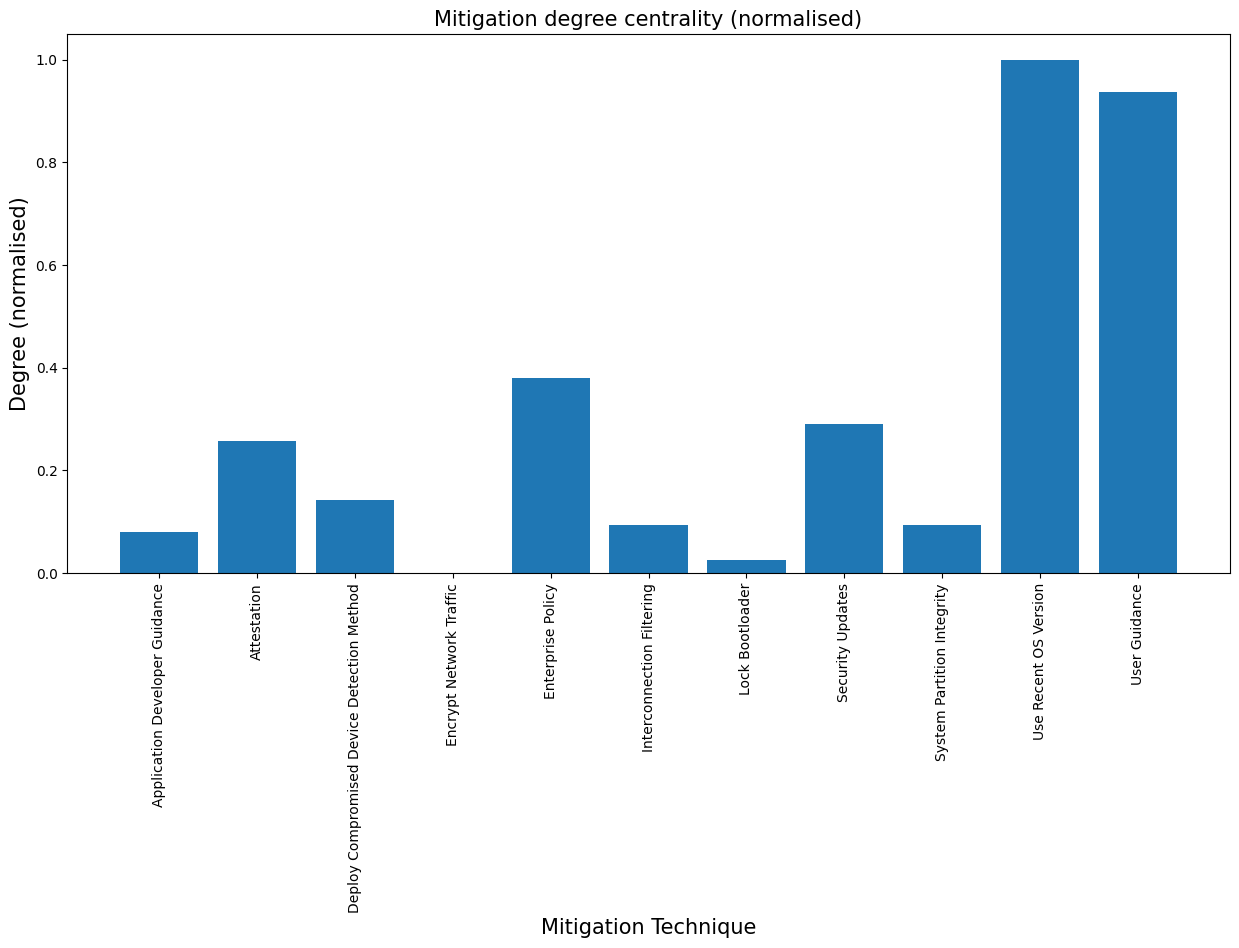

In [40]:
i=normalised_mit_degree.keys()
j=normalised_mit_degree.values()

plt.figure(figsize=[15, 7])
plt.bar(i,j)

plt.title('Mitigation degree centrality (normalised)', fontsize=15)
plt.xlabel('Mitigation Technique', fontsize=15)
plt.ylabel('Degree (normalised)', fontsize=15)
plt.xticks(rotation=90)

plt.savefig('figs/degree_centrality/mitigations_degree_centrality_normalised.png', dpi=300, bbox_inches='tight')


plt.show()

In [41]:
thresholds = {'low': (0.0, 0.1), 'medium': (0.1, 0.7), 'high': (0.7, 1.0)}

def find_label(value, thresholds):
    for label, (min_val, max_val) in thresholds.items():
        if min_val <= value <= max_val:
            return label

categorised_items = {'low': [], 'medium': [], 'high': []}

for key, value in normalised_mit_degree.items():
    label = find_label(value, thresholds)
    categorised_items[label].append((key, value))

for label, items in categorised_items.items():
    print(f"{label.capitalize()}:")
    for item in items:
        print(f"  {item[0]}: {item[1]}")
    print()

Low:
  Application Developer Guidance: 0.07881773399014781
  Encrypt Network Traffic: 0.0
  Interconnection Filtering: 0.09359605911330053
  Lock Bootloader: 0.02463054187192119
  System Partition Integrity: 0.09359605911330053

Medium:
  Attestation: 0.25615763546798037
  Deploy Compromised Device Detection Method: 0.1428571428571429
  Enterprise Policy: 0.3793103448275864
  Security Updates: 0.29064039408867

High:
  Use Recent OS Version: 1.0
  User Guidance: 0.9359605911330051



In [42]:
# Create a copy of the original dictionary
filtered_mitigations = mitigation_degree_centrality.copy()

# Remove 'Use Recent OS Version' and 'User Guidance' from the copied dictionary
del filtered_mitigations['Use Recent OS Version']
del filtered_mitigations['User Guidance']

# Normalize the data
min_value = min(filtered_mitigations.values())
max_value = max(filtered_mitigations.values())

normalised_filtered_degree = {
    key: (value - min_value) / (max_value - min_value)
    for key, value in filtered_mitigations.items()
}

print("-- Normalised mitigation degree centrality --")
for key, value in normalised_filtered_degree.items():
    print(f"{key}: {value}")


-- Normalised mitigation degree centrality --
Application Developer Guidance: 0.20779220779220775
Attestation: 0.6753246753246751
Deploy Compromised Device Detection Method: 0.3766233766233765
Encrypt Network Traffic: 0.0
Enterprise Policy: 1.0
Interconnection Filtering: 0.24675324675324672
Lock Bootloader: 0.06493506493506492
Security Updates: 0.7662337662337658
System Partition Integrity: 0.24675324675324672


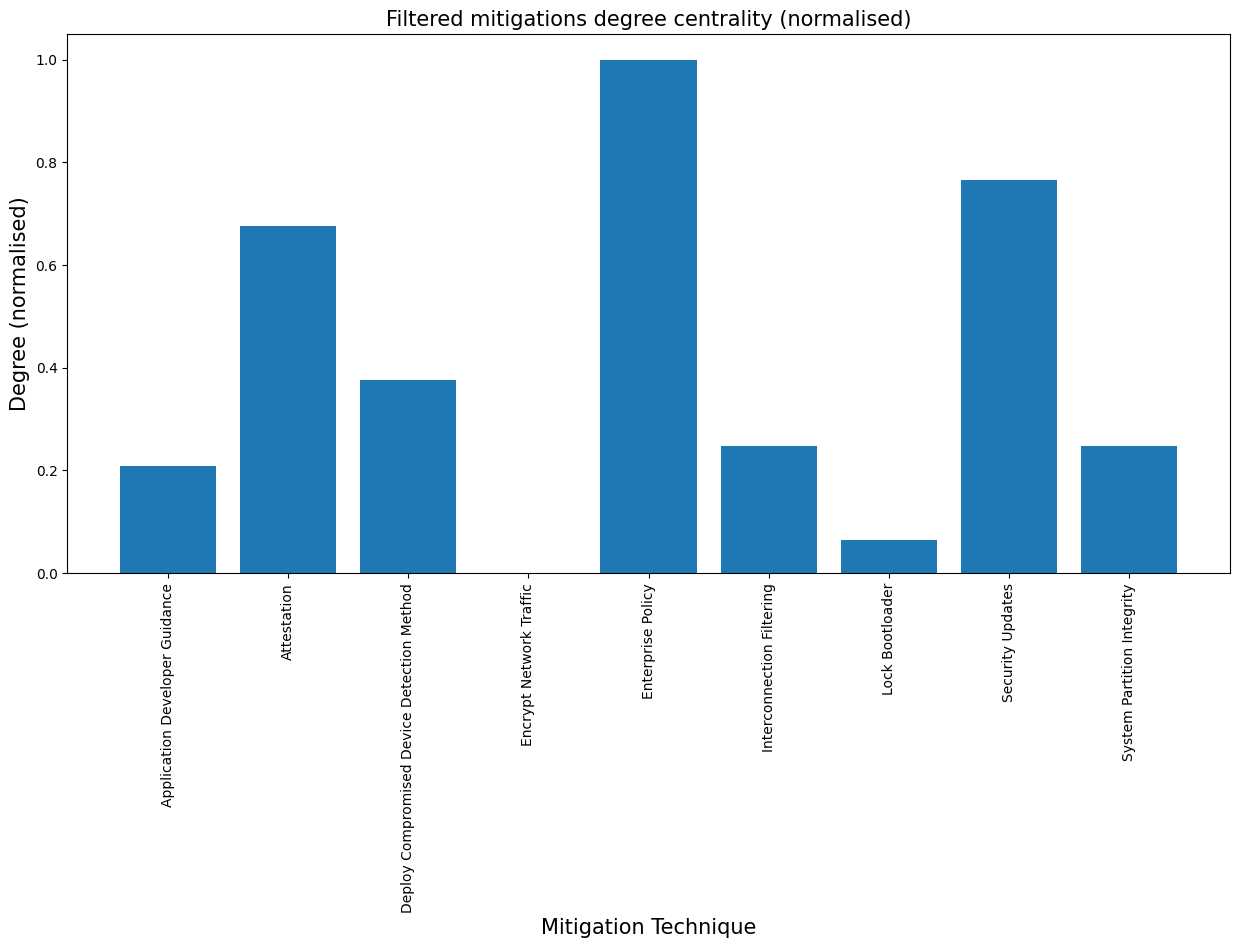

In [43]:
i=normalised_filtered_degree.keys()
j=normalised_filtered_degree.values()

plt.figure(figsize=[15, 7])
plt.bar(i,j)

plt.title('Filtered mitigations degree centrality (normalised)', fontsize=15)
plt.xlabel('Mitigation Technique', fontsize=15)
plt.ylabel('Degree (normalised)', fontsize=15)
plt.xticks(rotation=90)

plt.savefig('figs/degree_centrality/filtered_mitigations_degree_centrality_normalised.png', dpi=300, bbox_inches='tight')

plt.show()

In [44]:
thresholds = {'low': (0.0, 0.33), 'medium': (0.33, 0.66), 'high': (0.6, 1.0)}

def find_label(value, thresholds):
    for label, (min_val, max_val) in thresholds.items():
        if min_val <= value <= max_val:
            return label

categorised_items = {'low': [], 'medium': [], 'high': []}

for key, value in normalised_filtered_degree.items():
    label = find_label(value, thresholds)
    categorised_items[label].append((key, value))

for label, items in categorised_items.items():
    print(f"{label.capitalize()}:")
    for item in items:
        print(f"  {item[0]}: {item[1]}")
    print()

Low:
  Application Developer Guidance: 0.20779220779220775
  Encrypt Network Traffic: 0.0
  Interconnection Filtering: 0.24675324675324672
  Lock Bootloader: 0.06493506493506492
  System Partition Integrity: 0.24675324675324672

Medium:
  Deploy Compromised Device Detection Method: 0.3766233766233765

High:
  Attestation: 0.6753246753246751
  Enterprise Policy: 1.0
  Security Updates: 0.7662337662337658



/tmp/ipykernel_18933/497195646.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


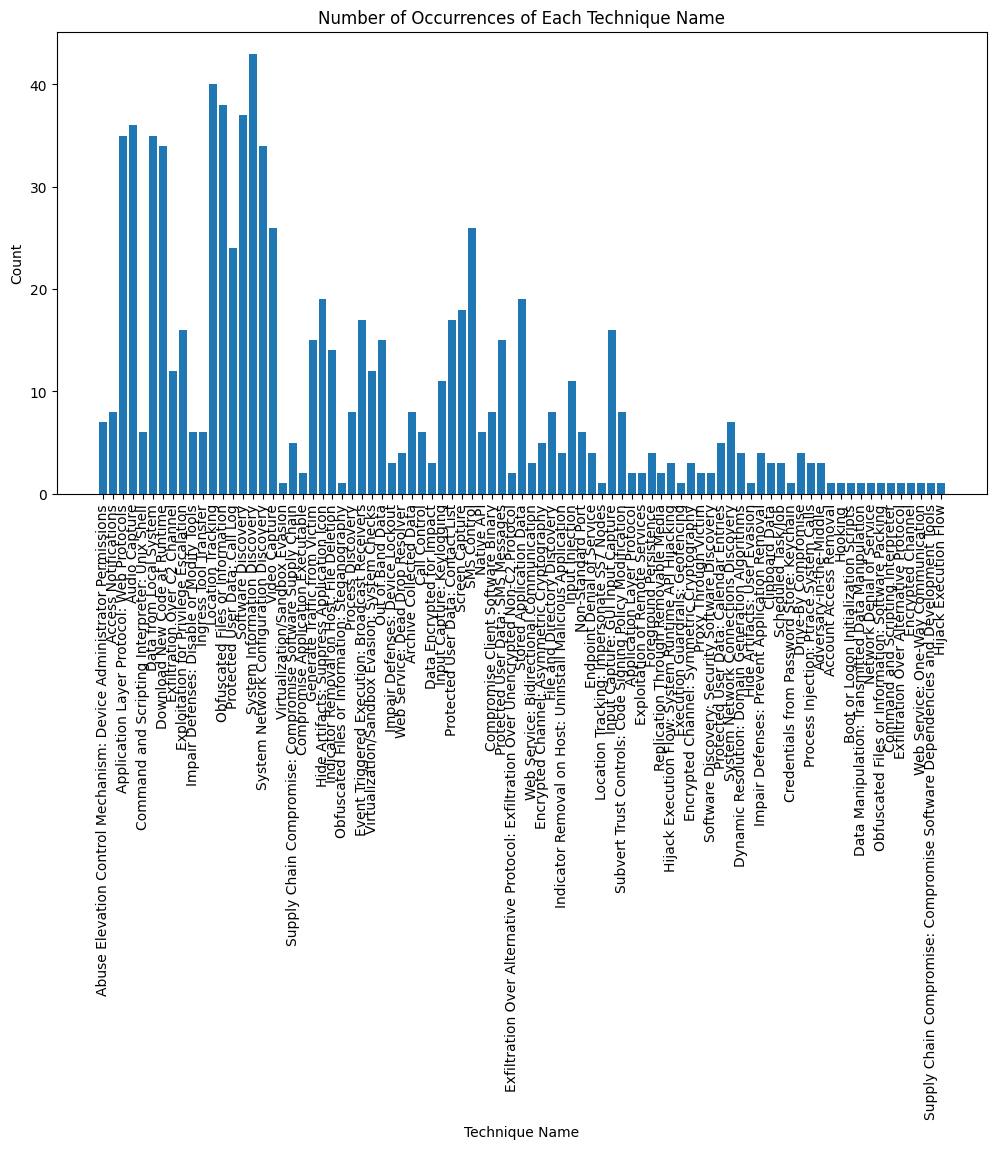

In [45]:
# Count the occurrences of each technique name
technique_counts = {}
for software in software_techniques:
    for technique in software['techniques']:
        technique_name = technique['technique_name']
        technique_counts[technique_name] = technique_counts.get(technique_name, 0) + 1

# Create the bar plot
technique_names = list(technique_counts.keys())
counts = list(technique_counts.values())

plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), counts)
plt.xticks(range(len(technique_names)), technique_names, rotation=90)
plt.xlabel('Technique Name')
plt.ylabel('Count')
plt.title('Number of Occurrences of Each Technique Name')
plt.tight_layout()
plt.show()
